In [ ]:
#default_exp bgseg_dataset_coco

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [ ]:
#export
from pathlib import PosixPath

path = PosixPath('/data/coco/')
path_lbl = path/'stuffthingmaps'/'all_labels'
path_img = path/'all_images'

In [ ]:
imnames = get_image_files(path_img)
imnames[:3]

[PosixPath('/data/coco/all_images/000000395203.jpg'),
 PosixPath('/data/coco/all_images/000000510719.jpg'),
 PosixPath('/data/coco/all_images/000000235699.jpg')]

In [ ]:
lblnames = get_image_files(path_lbl)
lblnames[:3]

[PosixPath('/data/coco/stuffthingmaps/all_labels/000000016831.png'),
 PosixPath('/data/coco/stuffthingmaps/all_labels/000000250395.png'),
 PosixPath('/data/coco/stuffthingmaps/all_labels/000000221547.png')]

In [ ]:
len(imnames), len(lblnames)

(123287, 123287)

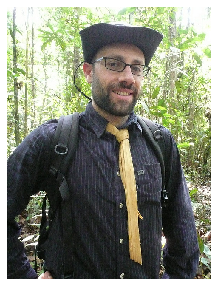

In [ ]:
img = open_image(imnames[0])
img.show(figsize=(5,5))

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'
# get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

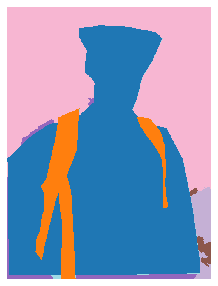

In [ ]:
mask = open_mask(get_y_fn(imnames[0]))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
person_idx = 0

In [ ]:
int((mask.data==person_idx).sum()) / mask.data.numel()

0.512646484375

In [ ]:
ppl_imnames = []
for imname in progress_bar(imnames):
    mask = open_mask(get_y_fn(imname))
    ppl_mask = (mask.data == person_idx)
    if ppl_mask.any():
        ppl_imnames.append(imname)
print('total nr of images w/ ppl:', len(ppl_imnames))

total nr of images w/ ppl: 66646


In [ ]:
big_ppl_imnames = []
for imname in progress_bar(ppl_imnames):
    mask = open_mask(get_y_fn(imname))
    ratio = int((mask.data==person_idx).sum()) / mask.data.numel()
    if ratio > 0.3:
        big_ppl_imnames.append(imname)
print('total nr of images w/ big ppl:', len(big_ppl_imnames))

total nr of images w/ big ppl: 11735


In [ ]:
# 0.3 - 11k
# 0.4 - 6.5k
# 0.5 - 3.5k

### filter faces

In [ ]:
import cv2

def cascade_detect_regions(img, cascade_classifier):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    img_gray = cv2.equalizeHist(img_gray)
    regions = cascade_classifier.detectMultiScale(img_gray)
    return [ (t,l,t+h,l+w) for (l,t,w,h) in regions] # out: (t,l,b,r)

face_cascade = cv2.CascadeClassifier()
face_cascade.load(cv2.samples.findFile('../haarcascades/haarcascade_frontalface_default.xml'))
detect_faces = lambda img: cascade_detect_regions(img, face_cascade)

In [ ]:
def prepare_image(image): # fastai.vision.Image
    return (image2np(image.data)*255).astype(np.uint8)

In [ ]:
def filter_no_faces(ppl_imnames):
    filtered_imnames = []
    for imname in progress_bar(ppl_imnames):
        image = open_image(imname)
        im = prepare_image(image)
        faces = detect_faces(im)
        if len(faces) > 0:
            filtered_imnames.append(imname)
    return filtered_imnames

In [ ]:
big_faces_imnames = filter_no_faces(big_ppl_imnames)

In [ ]:
# faces_imnames = filter_no_faces(ppl_imnames)

In [ ]:
# 11k (0.3t) -> 8.7k


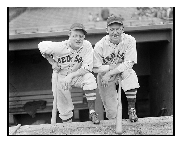

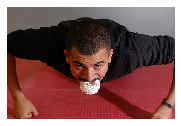

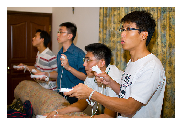

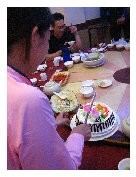

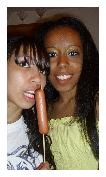

In [ ]:
for imname in progress_bar(big_faces_imnames[10:15]):
#     mask = open_mask(get_y_fn(imname))
    mask = open_image(imname)
    mask.show()

In [ ]:
#export
from pathlib import PosixPath

out_path_img = PosixPath('../data/seg/coco/images')
out_path_lbl = PosixPath('../data/seg/coco/labels')

In [ ]:
for imname in progress_bar(big_faces_imnames):
    # save mask
    mask = open_mask(get_y_fn(imname))
    ppl_mask = (mask.data == person_idx)
    new_mask = torch.zeros_like(mask.data)
    new_mask[ppl_mask] = 1
    mask = ImageSegment(new_mask)
    mask.save(out_path_lbl/f'{imname.stem}.png')
    # save img
    image = open_image(imname)
    image.save(out_path_img/f'{imname.stem}.jpg')

## Crop some of bg

In [ ]:
def get_ppl_crop_coors(ppl_mask): # [1,H,W] tensor
    hori_m = ppl_mask.sum(-2).squeeze() # [W]
    x = torch.arange(len(hori_m))[hori_m > 0] # indexes of pixels
    l,r = x[0], x[-1]
    vert_m = ppl_mask.sum(-1).squeeze() # [H]
    x = torch.arange(len(vert_m))[vert_m > 0] # indexes of pixels
    t,b = x[0], x[-1]
    return t,l,b,r

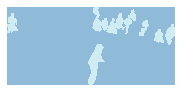

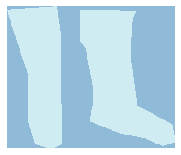

In [ ]:
for imname in progress_bar(imnames[1:10]):
    mask = open_mask(get_y_fn(imname))
    ppl_mask = (mask.data == person_idx)
    if ppl_mask.any():
        new_mask = torch.zeros_like(mask.data)
        new_mask[ppl_mask] = 1
        t,l,b,r = get_ppl_crop_coors(ppl_mask)
        im = Image(open_image(imname).data[:, t:b , l:r ])
        new_mask = ImageSegment(new_mask[:, t:b , l:r ])
        new_mask.show()

In [ ]:
m.data.unique(return_counts=True)

(tensor([  0,  13,  20,  29,  37,  56,  65,  87,  93,  95, 130, 201]),
 tensor([10095,  1041, 22547,  8705, 95701,  7873, 31286, 40485,  3162,  1688,
           975, 15802]))

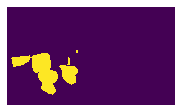

In [ ]:
m = torch.zeros_like(mask.data)
m[mask.data == 201] = 1
Image(m).show()

In [ ]:
def read_json(path):
    with open(path) as json_file:
        return json.load(json_file)

In [ ]:
j = read_json(path/'annotations'/'stuff_val2017.json')

In [ ]:
j_train = read_json(path/'annotations'/'stuff_train2017.json')

In [ ]:
for cat in j_train['categories']:
    print(cat)

{'supercategory': 'textile', 'id': 92, 'name': 'banner'}
{'supercategory': 'textile', 'id': 93, 'name': 'blanket'}
{'supercategory': 'plant', 'id': 94, 'name': 'branch'}
{'supercategory': 'building', 'id': 95, 'name': 'bridge'}
{'supercategory': 'building', 'id': 96, 'name': 'building-other'}
{'supercategory': 'plant', 'id': 97, 'name': 'bush'}
{'supercategory': 'furniture-stuff', 'id': 98, 'name': 'cabinet'}
{'supercategory': 'structural', 'id': 99, 'name': 'cage'}
{'supercategory': 'raw-material', 'id': 100, 'name': 'cardboard'}
{'supercategory': 'floor', 'id': 101, 'name': 'carpet'}
{'supercategory': 'ceiling', 'id': 102, 'name': 'ceiling-other'}
{'supercategory': 'ceiling', 'id': 103, 'name': 'ceiling-tile'}
{'supercategory': 'textile', 'id': 104, 'name': 'cloth'}
{'supercategory': 'textile', 'id': 105, 'name': 'clothes'}
{'supercategory': 'sky', 'id': 106, 'name': 'clouds'}
{'supercategory': 'furniture-stuff', 'id': 107, 'name': 'counter'}
{'supercategory': 'furniture-stuff', 'id'